In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import itertools 
from graphviz import Digraph

In [2]:
def plot_mat_corrs(figsize, annot, matrix):
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
    sns.heatmap(matrix, cmap=cmap, center=0, annot=annot, vmax = max(matrix.max()), vmin= min(matrix.min()))
    plt.yticks(rotation=45)
    plt.xticks(rotation=45)
    plt.show()

In [64]:
def sig_corr(x1, x2, wlag, t_amostragem):
    correlations = np.zeros(wlag)
    for i in np.arange(0, wlag):
        correlations[i] = (1/(len(x1) - i))*np.dot(x1[i:],x2[:(len(x2) - i)])
    max_index = np.argmax(np.abs(correlations))
    return ([max_index*t_amostragem, np.round(correlations[max_index],2)])

In [60]:
def normalize_df(df):  
    df_norm = (df - df.mean())/df.std()
    return df_norm
        

In [5]:
def corrs(dist_df, wlag, t_amostragem):
    corr = np.zeros([dist_df.columns.size,dist_df.columns.size,2])
    for i, col_a in enumerate(dist_df.columns):
        for j, col_b in enumerate(dist_df.columns):
            corr[i][j] = sig_corr(dist_df[col_a], dist_df[col_b], wlag, t_amostragem)         
    return corr


In [23]:
def graph(limit, df_te, df_lag ,eng ='dot'):
    g = Digraph(engine=eng)
    for k, row in enumerate(df_te.index):
        if any(abs(df_te.iloc[k]) > limit) or any(abs(df_te[row]) > limit):
            g.node(str(k),row, shape='oval', fontsize='10', width='0', rankdir="LR") 
    for j, col in enumerate(df_te.columns):
        for i, row in enumerate(df_te[col]):
            if abs(row) > limit and i !=j:
                g.edge(str(i), str(j), label=str(np.round(row,6)) + str(' - atraso: ') + str(df_lag[col][i]),\
                       color="#000000{:02x}".format(int(255)))
                #row//max(df_te.max())
    return g

In [7]:
def graph_simple(limit, df_te,eng ='dot'):
    g = Digraph(engine=eng)
    for k, row in enumerate(df_te.index):
        if any(abs(df_te.iloc[k]) > limit) or any(abs(df_te[row]) > limit):
            g.node(str(k),row, shape='oval', fontsize='10', width='0', rankdir="LR") 
    for j, col in enumerate(df_te.columns):
        for i, row in enumerate(df_te[col]):
            if abs(row) > limit and i !=j:
                g.edge(str(i), str(j), label=str(np.round(row,6)),\
                       color="#000000{:02x}".format(int(255)))
                #row//max(df_te.max())
    return g

In [8]:

def count_alarms(normal_w, abnormal_w, df):
    ''' count_alarms(normal_w, abnorma_w, df)'''
    df_count =  pd.DataFrame([], columns = df.columns, index= ['normal', 'abnormal', 'total'])
 
    for col in df.columns:
        n = 0
        normal = 0
        abnormal = 0
        total = 0

        while( n < df.shape[0]):
            abnormal = abnormal  + np.sum(df[col][n:n+abnormal_w])
            normal = normal + np.sum(df[col][n+abnormal_w: n+ normal_w])
            n= n + normal_w + abnormal_w


        total = np.sum(df[col])
        df_count[col][0] = normal
        df_count[col][1] = abnormal
        df_count[col][2] = total
    return df_count    

In [9]:
def generate_dfs_lag_corrs(matrix, columns_df):
    '''returns [df_corr, df_lag]'''
    corr_matrix = np.zeros([matrix.shape[0],matrix.shape[1]])
    lags_matrix = np.zeros([matrix.shape[0],matrix.shape[1]])
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            corr_matrix[i][j] = matrix[i][j][1]
            lags_matrix[i][j] = matrix[i][j][0]

    np.fill_diagonal(corr_matrix, 0)
    df_corr =  pd.DataFrame(corr_matrix, columns = columns_df, index= columns_df)
    df_lag =  pd.DataFrame(lags_matrix, columns = columns_df, index= columns_df)
    
    return [df_corr, df_lag]


In [10]:
#Contagem

dist6 = pd.read_csv('dist6.csv', names=['xmeas%02d_low' % x for x in range(1, 74)] + ['xmeas%02d_high' % x for x in range(1, 74)])
dist6_sel_vars = dist6[ ['xmeas01_low', 'xmeas02_low', 'xmeas03_low', 
        'xmeas08_low', 'xmeas09_low', 'xmeas21_low',
        'xmeas01_high', 'xmeas02_high', 'xmeas03_high', 'xmeas08_high', 'xmeas09_high', 'xmeas21_high']]

df_count =  pd.DataFrame([], columns = dist6_sel_vars.columns, index= ['normal', 'abnormal', 'total'])

dist6_first_diff = dist6_sel_vars.diff(1)
dist6_first_diff.iloc[0] = dist6_sel_vars.iloc[0]
dist6_first_diff = dist6_first_diff.clip(0,1).copy()

count_alarms(800,200,dist6_first_diff)

,xmeas01_low,xmeas02_low,xmeas03_low,xmeas08_low,xmeas09_low,xmeas21_low,xmeas01_high,xmeas02_high,xmeas03_high,xmeas08_high,xmeas09_high,xmeas21_high
normal,75,52,359,2254,64,807,72,149,1104,640,325,149
abnormal,1,12,11,0,259,3,0,17,115,1616,2,58
total,76,118,462,2258,337,834,72,170,1223,2356,338,327


In [65]:
#Process correlation
dist6_proc = pd.read_csv('dist6_3horas_sig/proc.csv')
dist6_proc.drop('tout', axis=1, inplace=True)


dist6_proc_svars = dist6_proc[['xmeas%02d' % x for x in [1,2,3,8,9,21]]]
dist6_proc_norm = normalize_df(dist6_proc_svars)
dist6_proc_norm.head()

cor_lag_mat = generate_dfs_lag_corrs(corrs(dist6_proc_norm, 50, 0.01),dist6_proc_svars.columns)

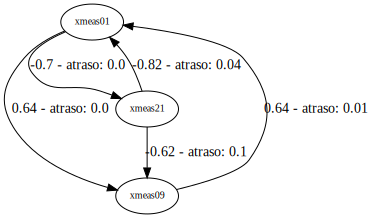

In [66]:
#graph of process correlation

graph(0.6, cor_lag_mat[0], cor_lag_mat[1], 'dot')

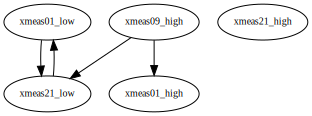

In [52]:
alrms = ['xmeas%02d_low' % x for x in [1,2,3,8,9,21]] + ['xmeas%02d_high' % x for x in [1,2,3,8,9,21]]

g = Digraph(engine='dot')
g.node("1",'xmeas01_low',  shape='oval', fontsize='10', width='0', rankdir="LR") 
g.node("2",'xmeas01_high', shape='oval', fontsize='10', width='0', rankdir="LR") 

g.node("4",'xmeas09_high', shape='oval', fontsize='10', width='0', rankdir="LR") 
g.node("5",'xmeas21_low', shape='oval', fontsize='10', width='0', rankdir="LR")
g.node("6",'xmeas21_high', shape='oval', fontsize='10', width='0', rankdir="LR") 

g.edge("1","5")
g.edge("5", "1")
g.edge("4", "5")
g.edge("4", "2")
g

In [ ]:
  for j, col in enumerate(df_te.columns):
        for i, row in enumerate(df_te[col]):
            if abs(row) > limit and i !=j:
                g.edge(str(i), str(j), label=str(np.round(row,6)),\
                       color="#000000{:02x}".format(int(255)))

In [66]:

#Teste do metodo de contagem
# teste = {'a': [1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1], 'b':[1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0], 'c':[1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0]}
# df =  pd.DataFrame(teste)

# df_count =  pd.DataFrame([], columns = df.columns, index= ['normal', 'abnormal'])

# normal_w = 5
# abnormal_w = 3
 
# for col in df.columns:
#     n = 0
#     normal = 0
#     abnormal = 0
    
#     while( n < df.shape[0]):
#        df = dist_roll #df which will be resampled

#         normal = normal + np.sum(df[col][n+abnormal_w: n+ normal_w])

#         n= n + normal_w + abnormal_w
#     df_count[col][0] = normal
#     df_count[col][1] = abnormal
        
# df_count


